In [1]:
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import nltk

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix


%matplotlib inline


# Getting Data & Assigning Sentiment

In [67]:
review_df = pd.read_csv('../smp_data/ME_NH_RI_reviews.csv', encoding='utf-8',low_memory=False)

In [68]:
#establish count of reviews for each prof
cnt_df = review_df[['profID','department']].groupby('profID').count().reset_index().rename(columns={'department': 'reviewcount'})
review_df = pd.merge(review_df,cnt_df,on='profID')

In [69]:
# get rid of any of the middle reviews, trying to balance positive and negative
revPosNeg = review_df.ix[(review_df['overall']<=2.0) | (review_df['overall'] == 5.0)]
revPosNeg = revPosNeg[['profID','genderBest','schoolname_s','department','overall','difficulty','cleanText','reviewcount']]

In [5]:
# assign sentiment positive or negative
# need to do vectorized version of this
def sentiment(row):
    if row['overall'] == 5:
        val = 1
    elif row['overall'] <= 2.0:
        val = 0
    else:
        val = -1
    return val

In [70]:
# assign sentiment to all the reviews
revPosNeg['sentiment'] = revPosNeg.apply(sentiment,axis=1)

In [7]:
#Basic Sentiment Counts by gender, note there are still more positive than negative reviews
revPosNeg[['genderBest','sentiment','profID']].groupby(['genderBest','sentiment']).count()

profID
genderBest sentiment        
female     0           15821
           1           22093
male       0           23989
           1           36792

In [34]:
#Basic Sentiment Counts by gender and department
countDepts = revPosNeg[['genderBest','sentiment','profID','department']].groupby(['genderBest','sentiment','department']).count().rename(columns={'profID':'count'})

# looking for sufficiently large departments to compare
# both have counts of larger than 1000 in positive and negative reviews for men and women
countDepts[countDepts['count']>1000]

count
genderBest sentiment department              
female     0         English             2031
                     Mathematics         1183
           1         Biology             1024
                     English             3339
                     Mathematics         1589
                     Psychology          1970
male       0         Biology             1072
                     Chemistry           1059
                     Computing           1039
                     Economics           1507
                     English             1575
                     History             1364
                     Mathematics         2899
                     Psychology          1343
           1         Biology             1611
                     Business            2399
                     Computing           1034
                     Economics           1300
                     English             3531
                     History             2177
                     Mathematics         2851
                     Philosophy          1305
                     Political Science   1478
                     Psychology          2369
                     Science             1263

Need to look just at departments that have sufficiently many reviews. Arbitrarily decided to place that at 1000.

In [37]:
#Deciding which counts to include for departments
#Look for departments with > 1000 reviews
countDepts = countDepts.reset_index()
depts = countDepts.loc[countDepts['count']>=1000,'department']

In [38]:
#selecting just those departments
revDepts_df = revPosNeg[revPosNeg['department'].isin(depts)].sort_values(by='department')

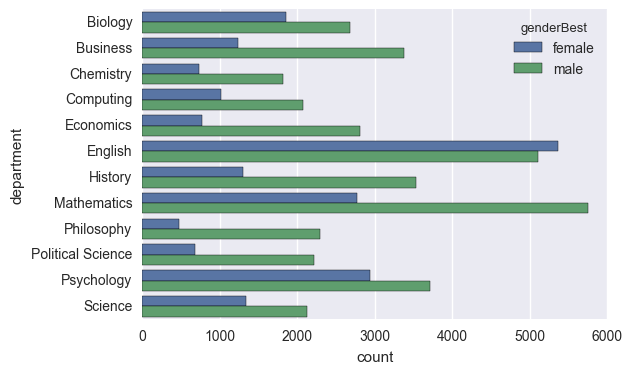

In [39]:
sns.countplot(y="department", data=revDepts_df, hue='genderBest');

Note that the sentiment varies by department and gender in some interesting ways. 

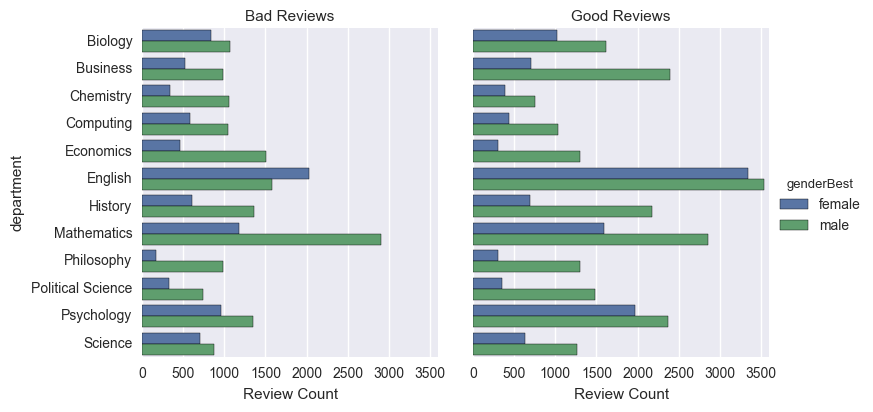

In [55]:
revDepts_df["nameSentim"] = revDepts_df["sentiment"].map({0: "Bad", 1: "Good"})

g = sns.factorplot(hue="genderBest",y='department',col='nameSentim',kind='count',data=revDepts_df);
(g.set_axis_labels("Review Count")
    .set_titles("{col_name} Reviews")
    .set(xlim=(0, 3600))
    .despine(left=True)); 

In the end, English and Math both have a sufficient number of review counts and also provide a nice contranst to each other, so I will look at those two departments and do some analysis.

# Trimming to Eng/Math and Getting content and stems

Saved this at the end so can just import it later if already done.

In [97]:
# import from csv if this is already complete
engMath_df = pd.read_csv('../smp_data/engMath_ME_NH_RI.csv',encoding='utf-8')

In [56]:
# Using snowball stemmer as it is improvement over Porter for reasons I do not know
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

stopwords = nltk.corpus.stopwords.words('english')

# return content words and their stems
def content_stems(text, stopwords):
    tokens = nltk.word_tokenize(text)
    content = [word for word in tokens if word.lower() not in stopwords]
    stems = [stemmer.stem(t) for t in content]
    return [content,stems]

In [79]:
engMath_df = revPosNeg[revPosNeg['department'].isin(['English','Mathematics'])]

In [80]:
# try using nltk.ConditionalFrequencyDistribution
# first tokenize and stem the reviews
engMath_df['stems'] = engMath_df['cleanText'].apply(lambda x: content_stems(x,stopwords)[1])


/Users/angelavierling-claassen/anaconda/envs/my_projects_env/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [81]:
engMath_df['words'] = engMath_df['cleanText'].apply(lambda x: content_stems(x,stopwords)[0])

/Users/angelavierling-claassen/anaconda/envs/my_projects_env/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [ ]:
# export this to csv
engMath_df.to_csv('../smp_data/engMath_ME_NH_RI.csv',encoding='utf-8', header=True, index=False)

In [194]:
def simplePredict(myList):
    if 'worst' in myList:
        return 0
    elif 'best' in myList:
        return 1
    elif 'good' in myList:
        return 1
    else:
        return 0

In [195]:
engMath_df['sentimentPredict']=engMath_df['stems'].apply(simplePredict)

In [183]:
from sklearn import cross_validation

In [196]:
confusion_matrix(engMath_df["sentiment"], engMath_df["sentimentPredict"])

array([[6943,  745],
       [8080, 3230]])

In [197]:
# model evaluation
from sklearn.metrics import classification_report
print(classification_report(engMath_df['sentiment'],engMath_df["sentimentPredict"]))

             precision    recall  f1-score   support

          0       0.46      0.90      0.61      7688
          1       0.81      0.29      0.42     11310

avg / total       0.67      0.54      0.50     18998



# Categorize Reviews

Have created 8 categories for reviews that correspond grouping binary variables B/G, E/M, F/N(Math).

In [98]:
# Create the three letter code
# code for these dataframes and fields
# letter 1 = Bad / Good (corresponding to 0 or 1 on 'sentiment')
# letter 2 = English / Math (with an N for 'number')
# letter 3 = Female / Male

# These should partition the data -- that is, they should sum up to all the reviews
# And no review should be in more than one code
engMath_df['code'] = np.where(engMath_df['sentiment'], 'G', 'B')
engMath_df['code'] = engMath_df['code'] + np.where(engMath_df['department']=='English', 'E','N')
engMath_df['code'] = engMath_df['code'] + np.where(engMath_df['genderBest']=='female','F','M')

In [104]:
import itertools
import ast

# Sample Reviews so categories are even

In [100]:
# count the number of reviews in each code
tots = engMath_df[['code','profID']].groupby('code').count().reset_index()

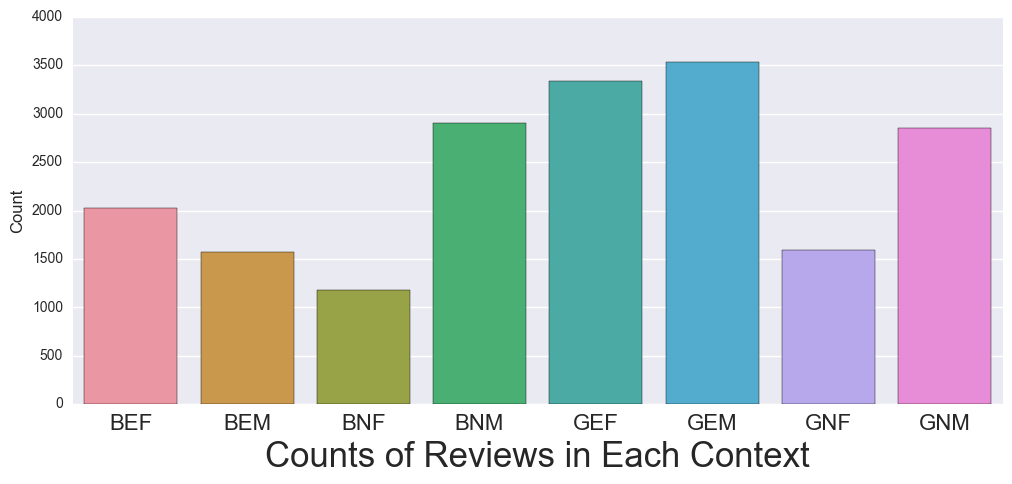

In [101]:
# barplot of counts for all different contexts
# will want to sample these so that they contexts are all equally represented
plt.rcParams["figure.figsize"] = [12,5]
plt.figure()
sns.barplot(x='code',y='profID',data = tots)
xticks = ['BEF','BEM','BNF','BNM','GEF','GEM','GNF','GNM']
plt.xticks(range(len(xticks)),xticks,fontsize=16)
plt.xlabel("Counts of Reviews in Each Context",fontsize=25)
plt.ylabel("Count",fontsize=12)
plt.show()


In [102]:
#sampling so there are 1100 reviews in each category
sampled_df = engMath_df[engMath_df['code']=='BEF'].sample(n=1100)
sampled_df = sampled_df.append(engMath_df[engMath_df['code']=='BEM'].sample(n=1100), ignore_index=True)
sampled_df = sampled_df.append(engMath_df[engMath_df['code']=='BNF'].sample(n=1100), ignore_index=True)
sampled_df = sampled_df.append(engMath_df[engMath_df['code']=='BNM'].sample(n=1100), ignore_index=True)
sampled_df = sampled_df.append(engMath_df[engMath_df['code']=='GEF'].sample(n=1100), ignore_index=True)
sampled_df = sampled_df.append(engMath_df[engMath_df['code']=='GEM'].sample(n=1100), ignore_index=True)
sampled_df = sampled_df.append(engMath_df[engMath_df['code']=='GNF'].sample(n=1100), ignore_index=True)
sampled_df = sampled_df.append(engMath_df[engMath_df['code']=='GNM'].sample(n=1100), ignore_index=True)

In [ ]:
# in reading from csv the "stems" column has become like a string (even though dtype is object)
sampled_df['stems'] = sampled_df['stems'].apply(ast.literal_eval)

In [106]:
# Define category-word pairs
def pairsDeptGend(rev_df):
    pairList=[]
    for row in rev_df:
        pairList.extend([(rev_df['code'],stem) for stem in rev_df['stems']])  
    return list(set(pairList))

In [113]:
pairList = sampled_df.apply(pairsDeptGend,axis=1)

In [114]:
pairList = list(itertools.chain(*list(pairList)))

In [117]:
# Conditional frequency distribution of all words
cfd = nltk.ConditionalFreqDist(pairList)

In [120]:
#example of looking a table of interesting words
codes = ['BEF', 'BEM', 'BNF', 'BNM', 'GEF', 'GEM', 'GNF', 'GNM']
words = ['nice','care','help','understand','funni','fun','humor']

In [119]:
cfd.tabulate(conditions=codes, samples=words)

          nice       care       help understand      funni        fun      humor 
BEF         68         26        106         62         10         12          3 
BEM         49         31         98         49         15         19          8 
BNF         79         38        176        152          3          4          4 
BNM         83         52        174        152         24          8          1 
GEF        114         90        326         54         58        103         18 
GEM         77         56        228         55         95         88         29 
GNF        118         81        465        199         30         40          5 
GNM         78         58        347        191         75         78         23 


In [118]:
# can pull most common words
cfd['BEF'].most_common(20)

[('class', 576),
 ('teacher', 249),
 ('take', 219),
 ('grade', 213),
 ('student', 164),
 ('paper', 162),
 ('teach', 154),
 ('like', 148),
 ('ever', 136),
 ('professor', 135),
 ('time', 134),
 ('comment', 132),
 ('doesnt', 124),
 ('one', 122),
 ('get', 122),
 ('assign', 121),
 ('would', 120),
 ('dont', 119),
 ('write', 116),
 ('shes', 114)]

# Make CFD into a dataframe

In [121]:
from collections import defaultdict

In [162]:
# Return the conditional frequency distribution as a dataframe
def cfdDF(data):
    cfd = {}
    for cond, freq in data:
        try:
            cfd[cond][freq] += 1
        except KeyError:
            try:
                cfd[cond][freq] = 1
            except KeyError:
                cfd[cond] = {freq: 1}
    cfd_df = pd.DataFrame(cfd).fillna(0)  
    return cfd_df.astype(int)

In [163]:
# create cfd dataframe
cfd_df = cfdDF(pairList)

In [165]:
#totaling up the words for the different cotexts
cfd_df['total'] = cfd_df[['BEF','GEF','BNF','GNF','BEM','GEM','BNM','GNM']].sum(axis=1)

In [166]:
# pulling the binary categories back out again
cfd_df['female']=cfd_df[['BEF','BNF','GEF','GNF']].sum(axis=1)
cfd_df['male']=cfd_df[['BEM','BNM','GEM','GNM']].sum(axis=1)
cfd_df['english']=cfd_df[['BEF','BEM','GEF','GEM']].sum(axis=1)
cfd_df['math']=cfd_df[['BNF','BNM','GNF','GNM']].sum(axis=1)
cfd_df['good']=cfd_df[['GEF','GEM','GNF','GNM']].sum(axis=1)
cfd_df['bad']=cfd_df[['BEF','BEM','BNF','BNM']].sum(axis=1)

In [126]:
cfd_df['gender']=cfd_df['female']-cfd_df['male']
cfd_df['dept']=cfd_df['english']-cfd_df['math']
cfd_df['quality']=cfd_df['bad']-cfd_df['good']

In [127]:
cfd_df = cfd_df.reset_index()

In [146]:
# total up all of the previously defined columns
# turn that into a df to graph
totals = cfd_df[['index','BEF', 'BEM', 'BNF', 'BNM', 'GEF', 'GEM', 'GNF', 'GNM','female','male','english','math','good','bad']].sum()
tot_df = pd.DataFrame(totals).drop('index').rename(columns={0:'count'}).reset_index()

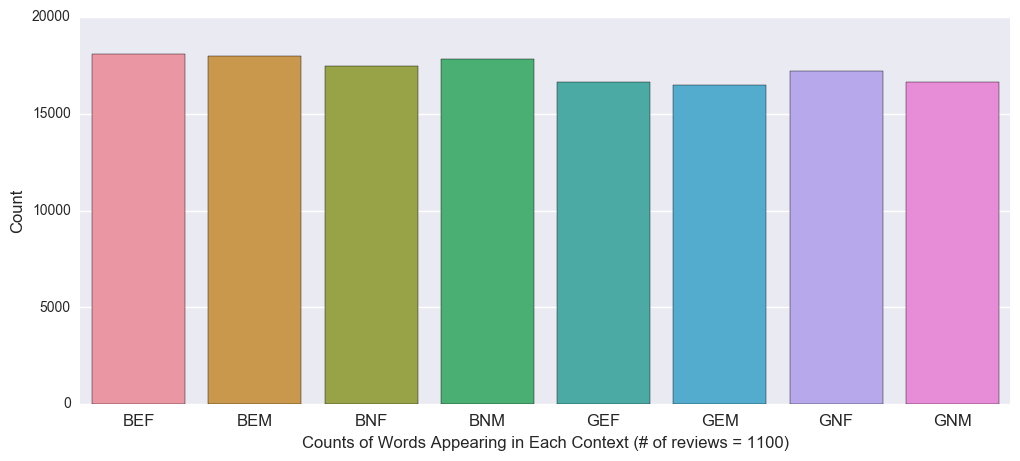

In [147]:
# barplot of word counts for codes
# these are tend to vary a lot as I re-sample
# getting more reviews scraped should help
plt.rcParams["figure.figsize"] = [12,5]
plt.figure()
sns.barplot(x='index',y='count',data = tot_df[0:8])
xticks = ['BEF', 'BEM', 'BNF', 'BNM', 'GEF', 'GEM', 'GNF', 'GNM']
plt.xticks(range(len(xticks)),xticks,fontsize=12)
plt.xlabel("Counts of Words Appearing in Each Context (# of reviews = 1100)",fontsize=12)
plt.ylabel("Count",fontsize=12)
plt.show()

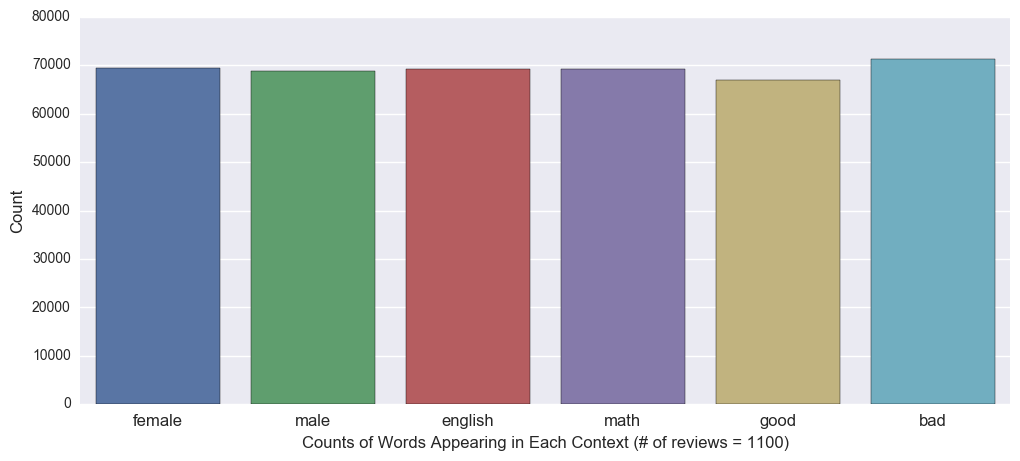

In [150]:
# barplot of wordcount by gender, dept, quality
# note these are basically equal
plt.rcParams["figure.figsize"] = [12,5]
plt.figure()
sns.barplot(x='index',y='count',data = tot_df[8:14])
plt.xticks(range(len(xticks)),xticks,fontsize=12)
plt.xlabel("Counts of Words Appearing in Each Context (# of reviews = 1100)",fontsize=12)
plt.ylabel("Count",fontsize=12)
plt.show()

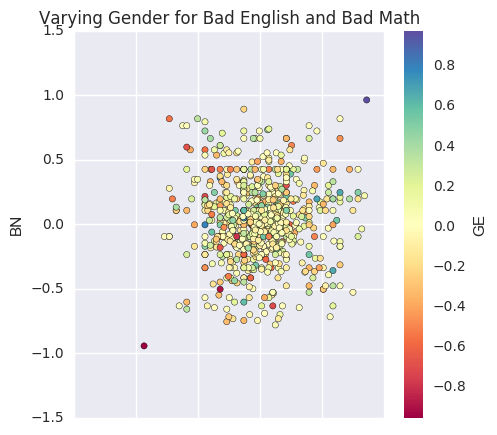

In [642]:
plt.rcParams["figure.figsize"] = [5,5]
plt.figure()


words_df.plot(
    kind='scatter',
    x='BE',
    y='BN',
    title="Varying Gender for Bad English and Bad Math",
    c = 'GE', #color
    cmap = 'Spectral'
)
#plt.xlim([-0.0001,0.05])
#plt.legend(['English Bad','Math Bad', 'English Good','Math Good'], loc=1, fontsize=12)
plt.show()

In [153]:
import plotly.plotly as py
import plotly.graph_objs as go


In [154]:
# plotly plot -- have to put in API to run this
# current version at https://plot.ly/~faroop/8
# allows for hover to see word
# scatter of gender and department with quality giving the colors
trace = go.Scatter(
    x=cfd_df['gender'],
    y=cfd_df['dept'],
    text=cfd_df['index'],
    mode = 'markers',
    marker = dict(
        size = 10,
        color = cfd_df['quality'],
        colorscale='Viridis',
        showscale = True,
        line = dict(
            width = 1,
        )
    )
)

data = [trace]

layout = dict(title = 'Gender vs Department, colored by Quality',
              hovermode = 'closest',
              yaxis = dict(title='Department'),
              xaxis = dict(title = 'Gender')
             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='reviewText2')

# Finding Interesting Words

To find words that vary across contexts, need to look far enough away from the origin. Note that words are right on an axis and look very large may not be interesting, but instead are obvious words like "math" or "she's". Best to trim those off.

In [156]:
interesting = cfd_df[((cfd_df['gender'])^2+(cfd_df['dept'])^2+(cfd_df['quality'])^2)>75^2]

In [159]:
# I know this is just a cheat but I am tired!
interesting.spacer=0

/Users/angelavierling-claassen/anaconda/envs/my_projects_env/lib/python3.5/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [167]:
int_words = ['answer',
             'aw'
 'alway',
 'anyth',
 'avail',
 "away",
 'board',
 'care',
 'chanc',
 'chang',
 'clear',
 'easi',
 'enjoy',
 'ever',
    'feel',
 'fun',
 'funni',
 'gpa',
 'grade',
 'great',
 'help',
             'homework',
 'hour',
 'interest',
 'lectur',
 'like',
  'professor',
 'recommend',
             'rude',
 'said',
 'say',
 'stupid',
 'succeed',
 'unclear',
 'year',
 'worst',
 'would']

In [168]:
int=interesting[['index','BEF','GEF','BNF','GNF','spacer','BEM','GEM','BNM','GNM']]
int = int[int['index'].isin(int_words)].sort_values('index', ascending=True)

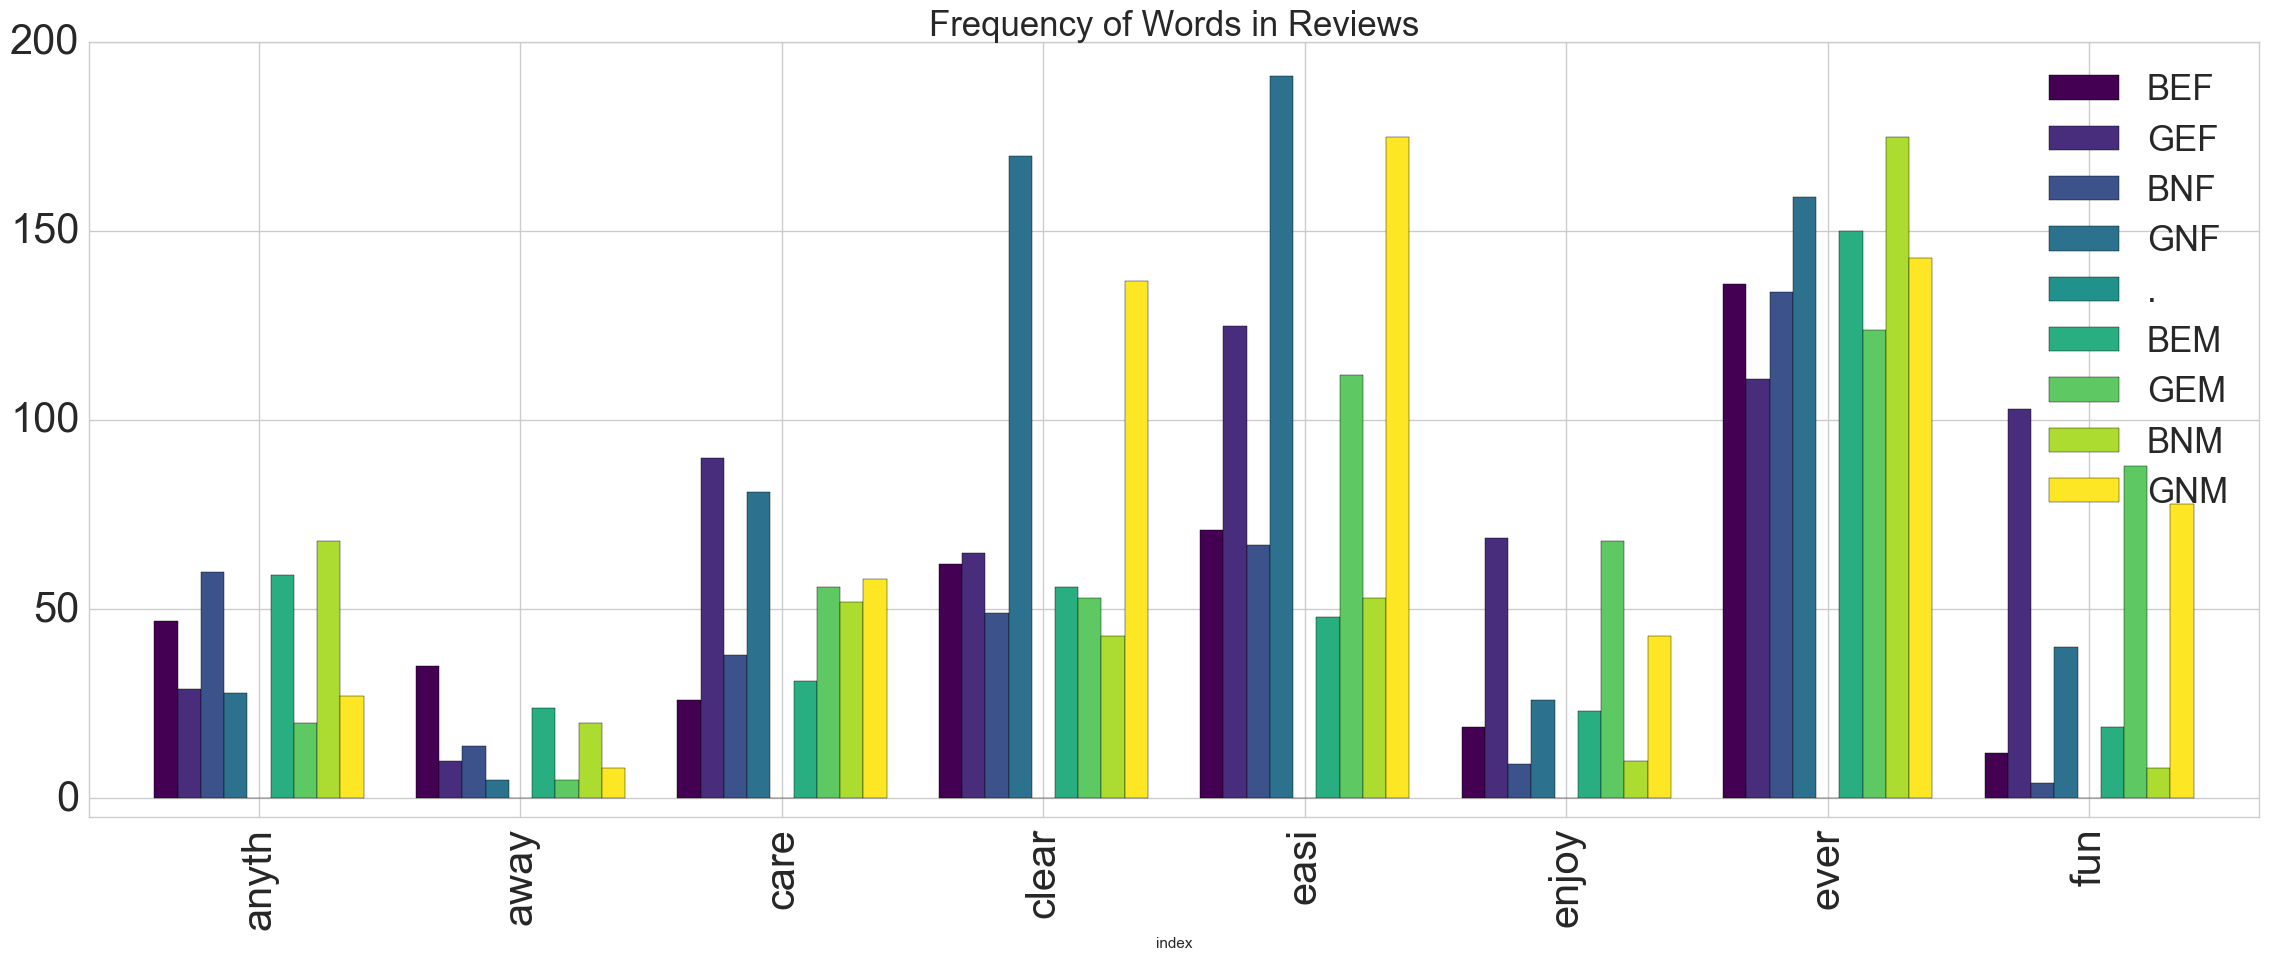

In [169]:
sns.set(style="whitegrid")

plt.rcParams["figure.figsize"] = [28,10]
plt.figure()

#g = sns.FacetGrid(interesting, col="index", col_wrap=4, size=2, ylim=(0, 1000))
#g.map(sns.barplot, 'index', 'BEF','GEF','BNF','GNF','BEM','GEM','BNM','GNM');
#ax = df[['V1','V2']].plot(kind='bar', title ="V comp", figsize=(15, 10), legend=True, fontsize=12)

int[['index', 'BEF','GEF','BNF','GNF','spacer','BEM','GEM','BNM','GNM']][0:8].plot(
    kind='bar',
    x='index',
    width=.8,
    title="Frequency of Words in Reviews",
    cmap=plt.cm.viridis,
    fontsize=25
)
plt.ylim([-5,200])

plt.tick_params(labelsize=30)
plt.title('Frequency of Words in Reviews',fontsize=25)
plt.legend(['BEF','GEF','BNF','GNF','.','BEM','GEM','BNM','GNM'], loc=1, fontsize=25)
plt.show()


# Predict Sentiment from Text

In [258]:
# Including only departments with over 800 profs for both men & women in both sentiments
revSet_df = revPosNeg[revPosNeg['department'].isin(['English','Mathematics','Biology','Psychology'])]
revSet_df = revSet_df[['profID','genderBest','department','sentiment','cleanText','words']]

In [259]:
# only use reviews where text is not "no comments"
revSet_df = revSet_df[revSet_df['cleanText']!="no comments "]

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [431]:
# pick out the train and the test sets
train_set = revSet_df

#pulling out the test set
test_set = train_set.sample(frac=.2,random_state=2411)
train_set=train_set.drop(test_set.index)
# training to the sentiment
y_train = train_set['sentiment']
y_test = test_set['sentiment']


# Initialize TFIDF vectorizor object (no n-grams)
vectorizer = TfidfVectorizer( max_features = 40000, sublinear_tf = True )

# fit_transform() fits the model & and learns the vocab (features)
# then it transforms the training data into feature vectors. 
# The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(train_set['cleanText'])

# convert to array
train_data_features = train_data_features.toarray()

In [432]:
# vocab = feature names
vocab = vectorizer.get_feature_names()

In [433]:
# Initialize a Random Forest classifier with 100 trees
# oob_score gives "out of bag" errors
forest = RandomForestClassifier(n_estimators = 100,oob_score=True) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit( train_data_features, y_train )

In [434]:
# how does the train set do on the out of bag reviews?
forest.oob_score_

0.92674234424498414

In [404]:
# cross-validation
# note need to update to latest sklearn which has this under sklearn.model_selection
from sklearn import cross_validation

In [412]:
# this cross validation is very costly
# may just want to go with the oob score (note that it is very close to cv score)
scores = cross_validation.cross_val_score(forest, train_data_features, y_train, cv=5)
scores

array([ 0.90739111,  0.8974923 ,  0.90739111,  0.90255169,  0.9040493 ])

In [415]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.01)


In [435]:
# look at result on train data
trainResult = forest.predict(train_data_features)

In [436]:
# confusion matrix for train data
confusion_matrix(train_set["sentiment"], trainResult)

array([[ 8715,    15],
       [    0, 13998]])

# Model Output and Evaluation

In [437]:
# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(test_set['cleanText'])
test_data_features = test_data_features.toarray()

In [439]:
# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)

# Copy the results to a pandas dataframe with an "profID" & sentiment prediction
output = pd.DataFrame( data={'sentimentActual':test_set["sentiment"], 'gender':test_set['genderBest'],'depart':test_set['department'], "sentimentPredict":result} )

In [440]:
output.head()

,depart,gender,sentimentActual,sentimentPredict
54508,Psychology,male,0,0
84198,Mathematics,male,1,1
167292,Mathematics,male,0,0
98784,Mathematics,female,1,1
164264,English,male,0,0


In [441]:
confusion_matrix(test_set["sentiment"], result)

array([[1965,  265],
       [  99, 3353]])

In [355]:
# model evaluation
from sklearn.metrics import classification_report

In [442]:
print(classification_report(test_set['sentiment'],result))

             precision    recall  f1-score   support

          0       0.95      0.88      0.92      2230
          1       0.93      0.97      0.95      3452

avg / total       0.94      0.94      0.94      5682



# Which Words are Most Important?

In [373]:
importances = forest.feature_importances_

In [379]:
imp_df = pd.DataFrame({'vocab':vocab,'import':importances}).sort_values('import')

In [452]:
# important words
imp_df[-20:]

,import,vocab
8044,0.006369,interesting
7100,0.006634,helpful
8208,0.006739,is
16625,0.007143,unclear
4686,0.007178,easy
15663,0.007429,teacher
1186,0.007955,awful
16043,0.008135,this
15834,0.008204,terrible
1827,0.008227,boring


In [443]:
wrong = output[output['sentimentActual']!=output['sentimentPredict']]

In [444]:
wrong.groupby('gender').count()/test_set.groupby('gender').count().sum()

,depart,sentimentActual,sentimentPredict
gender,,,
female,0.508242,0.508242,0.508242
male,0.491758,0.491758,0.491758


In [450]:
#Incorrect 7.7% of time for women. 5.5% for men
#Likely this is because men are represented in more reviews
wrong.groupby('gender')['gender'].count()/test_set.groupby('genderBest')['genderBest'].count()

gender
female    0.076605
male      0.054790
dtype: float64

In [451]:
#Department also breaks out with percentages being roughly like frequency
wrong.groupby('depart')['depart'].count()/test_set.groupby('department')['department'].count()

depart
Biology        0.047181
English        0.066869
Mathematics    0.070327
Psychology     0.063218
dtype: float64

# Gender Differences: Female Professors

In [550]:
# Female professors
femaleSet_df = revPosNeg[(revPosNeg['department'].isin(['English','Mathematics','Biology','Psychology']))&(revPosNeg['genderBest']=='female')]
femaleSet_df = revSet_df[['profID','genderBest','department','sentiment','cleanText','words']]

In [551]:
# only use reviews where text is not "no comments"
femaleSet_df = femaleSet_df[revSet_df['cleanText']!="no comments "]

In [552]:
# pick out the train and the test sets
train_set = femaleSet_df

#pulling out the test set
test_set = train_set.sample(frac=.2,random_state=2411)
train_set=train_set.drop(test_set.index)
# training to the sentiment
y_train = train_set['sentiment']
y_test = test_set['sentiment']


# Initialize TFIDF vectorizor object (no n-grams)
vectorizer = TfidfVectorizer( max_features = 40000, sublinear_tf = True )

# fit_transform() fits the model & and learns the vocab (features)
# then it transforms the training data into feature vectors. 
# The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(train_set['cleanText'])

# convert to array
train_data_features = train_data_features.toarray()

In [553]:
# Initialize a Random Forest classifier with 100 trees
# oob_score gives "out of bag" errors
forest = RandomForestClassifier(n_estimators = 100,oob_score=True) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit( train_data_features, y_train )

In [554]:
# vocab = feature names
vocab = vectorizer.get_feature_names()

In [555]:
# how does the train set do on the out of bag reviews?
forest.oob_score_

0.92705033438929951

In [556]:
# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(test_set['cleanText'])
test_data_features = test_data_features.toarray()

In [557]:
# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)

# Copy the results to a pandas dataframe with an "profID" & sentiment prediction
output = pd.DataFrame( data={'sentimentActual':test_set["sentiment"], 'gender':test_set['genderBest'],'depart':test_set['department'], "sentimentPredict":result} )

In [558]:
femImportances = forest.feature_importances_

In [559]:
confusion_matrix(test_set["sentiment"], result)

array([[1950,  280],
       [ 108, 3344]])

In [560]:
femImp_df = pd.DataFrame({'vocab':vocab,'import':femImportances}).sort_values('import')

In [562]:
#imp_df = imp_df.reset_index()
femImp_df = femImp_df.reset_index()

In [527]:
impVocabBoth=pd.merge(imp_df[-100:],femImp_df[-100:],on='vocab',how='outer',suffixes=('_all','_fem'),indicator=True)

In [543]:
impVocabBoth

,level_0,index_all,import_all,vocab,index_fem,import_fem,_merge
0,17865.0,5201.0,0.002149,even,5181.0,0.002188,both
1,17866.0,2273.0,0.002150,cares,2273.0,0.002369,both
2,17867.0,15155.0,0.002157,students,15141.0,0.002213,both
3,17868.0,10810.0,0.002163,only,NaN,NaN,left_only
4,17869.0,6777.0,0.002203,guy,6755.0,0.002253,both
5,17870.0,16262.0,0.002224,too,16256.0,0.002107,both
6,17871.0,2716.0,0.002262,clear,2721.0,0.002156,both
7,17872.0,8454.0,0.002267,just,8401.0,0.002426,both
8,17873.0,9393.0,0.002288,makes,9366.0,0.002245,both
9,17874.0,1773.0,0.002304,book,1769.0,0.002266,both


# Male professors

In [528]:
# Male professors
maleSet_df = revPosNeg[(revPosNeg['department'].isin(['English','Mathematics','Biology','Psychology']))&(revPosNeg['genderBest']=='male')]
maleSet_df = revSet_df[['profID','genderBest','department','sentiment','cleanText','words']]

In [529]:
# only use reviews where text is not "no comments"
maleSet_df = maleSet_df[revSet_df['cleanText']!="no comments "]

In [530]:
# pick out the train and the test sets
train_set = maleSet_df

#pulling out the test set
test_set = train_set.sample(frac=.2,random_state=2411)
train_set=train_set.drop(test_set.index)
# training to the sentiment
y_train = train_set['sentiment']
y_test = test_set['sentiment']


# Initialize TFIDF vectorizor object (no n-grams)
vectorizer = TfidfVectorizer( max_features = 40000, sublinear_tf = True )

# fit_transform() fits the model & and learns the vocab (features)
# then it transforms the training data into feature vectors. 
# The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(train_set['cleanText'])

# convert to array
train_data_features = train_data_features.toarray()

In [531]:
# Initialize a Random Forest classifier with 100 trees
# oob_score gives "out of bag" errors
forest = RandomForestClassifier(n_estimators = 100,oob_score=True) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit( train_data_features, y_train )

In [532]:
# vocab = feature names
vocab = vectorizer.get_feature_names()

In [533]:
# how does the train set do on the out of bag reviews?
forest.oob_score_

0.92559838085181279

In [534]:
# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(test_set['cleanText'])
test_data_features = test_data_features.toarray()

In [535]:
# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)

# Copy the results to a pandas dataframe with an "profID" & sentiment prediction
output = pd.DataFrame( data={'sentimentActual':test_set["sentiment"], 'gender':test_set['genderBest'],'depart':test_set['department'], "sentimentPredict":result} )

In [536]:
maleImportances = forest.feature_importances_

In [537]:
maleImp_df = pd.DataFrame({'vocab':vocab,'import':femImportances}).sort_values('import')

In [538]:
#imp_df = imp_df.reset_index()
maleImp_df = maleImp_df.reset_index()

In [542]:
maleImp_df[-50:]

,index,import,vocab
17910,17247,0.003319,waste
17911,7678,0.003396,in
17912,5191,0.003411,ever
17913,17431,0.003446,when
17914,1014,0.003454,at
17915,17519,0.003626,willing
17916,6487,0.003768,good
17917,10678,0.003884,of
17918,435,0.003945,all
17919,6992,0.003948,he


In [546]:
impVocabBoth.head()

,level_0,index_all,import_all,vocab,index_fem,import_fem,_merge
0,17865.0,5201.0,0.002149,even,5181.0,0.002188,both
1,17866.0,2273.0,0.002150,cares,2273.0,0.002369,both
2,17867.0,15155.0,0.002157,students,15141.0,0.002213,both
3,17868.0,10810.0,0.002163,only,NaN,NaN,left_only
4,17869.0,6777.0,0.002203,guy,6755.0,0.002253,both


In [563]:
impVocabMF=pd.merge(femImp_df[-100:],maleImp_df[-100:],on='vocab',how='outer',suffixes=('_fem','_male'),indicator=True)

In [567]:
impVocabMF['diff']=impVocabMF['import_fem']-impVocabMF['import_male']

In [582]:
impVocabMF = impVocabMF[['vocab','import_fem','import_male']].fillna(0)

In [587]:
impVocabMF['femRank']=impVocabMF['import_fem'].rank(ascending=0)
impVocabMF['maleRank']=impVocabMF['import_male'].rank(ascending=0)
impVocabMF['rankDiff']=impVocabMF['femRank']-impVocabMF['maleRank']

In [588]:
impVocabMF.sort_values('rankDiff')

,vocab,import_fem,import_male,femRank,maleRank,rankDiff
50,like,0.003423,0.002654,50.0,69.0,-19.0
36,or,0.002858,0.002441,64.0,79.0,-15.0
21,dr,0.002512,0.002196,79.0,93.0,-14.0
57,nothing,0.003832,0.003037,43.0,56.0,-13.0
9,yourself,0.002242,0.000000,91.0,103.5,-12.5
20,makes,0.002454,0.002245,80.0,91.0,-11.0
7,prof,0.002176,0.000000,93.0,103.5,-10.5
48,love,0.003103,0.002873,52.0,62.0,-10.0
87,this,0.007387,0.006219,13.0,23.0,-10.0
46,take,0.003061,0.002844,54.0,63.0,-9.0
